
# Extract Tfidf from data and save it for fast access

 
First, we'll load some python modules and define some variables


In [1]:
%matplotlib inline

from IPython import display
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# overwrite ipython defaults
plt.rcParams["figure.facecolor"] = '17344A'
plt.rcParams["axes.facecolor"] = '17344A'
plt.rcParams["figure.figsize"] = (10, 8)

import warnings
warnings.filterwarnings("ignore")

TRAININGFILE = "data/AllViolations.csv" #"data/train_labels.csv"
P1SUBFORMATFILE = "data/SubmissionFormat.csv"
P2SUBFORMATFILE = "data/PhaseIISubmissionFormat.csv"
TRAINOUTFILE = "features/train_tfidfLAG2A"
P1OUTFILE = "features/test1_tfidfLAG2"
P2OUTFILE = "features/test2_tfidfLAG2"

<a id="digging"></a>

# Loading the data

---------------

We'll start by taking a look at the data that is provided--more details on the  [problem description page](www.drivendata.org/competitions/5/page/28/) for the competition.

There are two types of data: 
 1. Yelp reviews, business information, users, tips, and check-ins 
 2. Historical hygeine violations as recorded by Boston public health inspectors


In [2]:
# List all the files in the data folder
!ls data

AllViolations.csv		train_labels.csv
business_id.txt			yelp_academic_dataset_business.json
PhaseIAnswer.csv		yelp_academic_dataset_checkin.json
PhaseIISubmissionFormat.csv	yelp_academic_dataset_review.json
restaurant_ids_to_yelp_ids.csv	yelp_academic_dataset_tip.json
SubmissionFormat.csv		yelp_academic_dataset_user.json


In [3]:
# Yelp reviews appear as a single JSON object per line in the file.
# Write the first line of the review file to look at the structure.
! head -n 1 data/yelp_academic_dataset_review.json

{"votes": {"funny": 0, "useful": 0, "cool": 0}, "user_id": "P_Mk0ygOilLJo4_WEvabAA", "review_id": "OeT5kgUOe3vcN7H6ImVmZQ", "stars": 3, "date": "2005-08-26", "text": "This is a pretty typical cafe.  The sandwiches and wraps are good but a little overpriced and the food items are the same.  The chicken caesar salad wrap is my favorite here but everything else is pretty much par for the course.", "type": "review", "business_id": "Jp9svt7sRT4zwdbzQ8KQmw"}


First, we will load in the mappings of `restaurant_id` in the Boston data to `business_id` in the Yelp data. We'll create a dictionary where the keys are Yelp IDs and the values are Boston IDs, and we'll use this later to figure out which restaurant reviews match which hygeine inspections. The dictionary will have the form `business_id: restaurant_id` and look something like:

```
{'W3Lfq_Cmqetp1f1AeupM9w': 'WeEe2m3a',
 'nCGr8lh1FlqzXjtVjUbiNg': 'njoZ5X3r',
 'PvuhIUdbironQ4zNbdU8gA': 'B1oXQmOV',
 'KAb0zhEL3MEhIJ8pLd1OpA': '8gOq01o2',
 ...
}
```

In [4]:
id_map = pd.read_csv("data/restaurant_ids_to_yelp_ids.csv")
id_dict = {}

# each Yelp ID may correspond to up to 4 Boston IDs
for i, row in id_map.iterrows():
    # get the Boston ID
    boston_id = row["restaurant_id"]
    
    # get the non-null Yelp IDs
    non_null_mask = ~pd.isnull(row.ix[1:])
    yelp_ids = row[1:][non_null_mask].values
    
    for yelp_id in yelp_ids:
        id_dict[yelp_id] = boston_id

Next, we'll load in the restaurant reviews. The code below creates a dataframe where each row is a single review from the Yelp dataset. In addition to dropping some of the columns that we won't use in this analysis (though that will probably be relevant to you), we use the ID mapping dictionary we just created to replace the Yelp IDs with the ones in the Boston dataset.

In [5]:
with open("data/yelp_academic_dataset_review.json", 'r') as review_file:
    # the file is not actually valid json since each line is an individual
    # dict -- we will add brackets on the very beginning and ending in order
    # to make this an array of dicts and join the array entries with commas
    review_json = '[' + ','.join(review_file.readlines()) + ']'

# read in the json as a DataFrame
reviews = pd.read_json(review_json)

# drop columns that we won't use
reviews.drop(['review_id', 'type', 'user_id', 'votes'], 
             inplace=True, 
             axis=1)

# replace yelp business_id with boston restaurant_id
map_to_boston_ids = lambda yelp_id: id_dict[yelp_id] if yelp_id in id_dict else np.nan
reviews.business_id = reviews.business_id.map(map_to_boston_ids)

# rename first column to restaurant_id so we can join with boston data
reviews.columns = ["restaurant_id", "date", "stars", "text"]    

# drop restaurants not found in boston data
reviews = reviews[pd.notnull(reviews.restaurant_id)]

reviews.head()

restaurant_id       date  stars  \
0      N6Ok7qOx 2005-08-26      3   
1      N6Ok7qOx 2005-11-23      3   
2      N6Ok7qOx 2005-11-23      3   
3      N6Ok7qOx 2006-02-24      5   
4      N6Ok7qOx 2007-09-06      3   

                                                text  
0  This is a pretty typical cafe.  The sandwiches...  
1  I agree with other reviewers - this is a prett...  
2  Decent enough food, but very overpriced. Just ...  
3  The muffins are great...esp the blueberry!  I ...  
4  Well, well, well, look at me reviewing the res...

Now that we have our review data from Yelp, we'll load our data for Boston as well. The training data has:

 * `id` - a unique ID per inspection
 * `date` - the date of the inspection
 * `restaurant_id` - a unqiue identifier for the restaurant
 * `*` - the number of minor violations
 * `**` - the number of major violations
 * `***` - the number of severe violations
 
The `SUBMISSIONFILE` file looks the same, but the violation counts are all zeros. We are going to predict the violation counts for the inspections in that test set. That is, for each inspection (unqiue date/restaurant combination) how many violations of each level did inspectors uncover?

In [6]:
train_labels = pd.read_csv(TRAININGFILE, index_col=0)
submission1 = pd.read_csv(P1SUBFORMATFILE, index_col=0)
submission2 = pd.read_csv(P2SUBFORMATFILE, index_col=0)
submission2 = submission2.iloc[0:1867]
train_labels.head()

date restaurant_id  *  **  ***
20619  2006-04-04      6VOp6a3L  7   0    2
10144  2006-10-04      1JEbP4oR  0   0    0
19634  2006-10-16      Pk3w02od  6   1    2
24797  2006-10-19      1JEbP4oR  0   0    0
20253  2006-11-17      N6OkmQ3x  0   0    0

We can plot these violations to see how many occured.

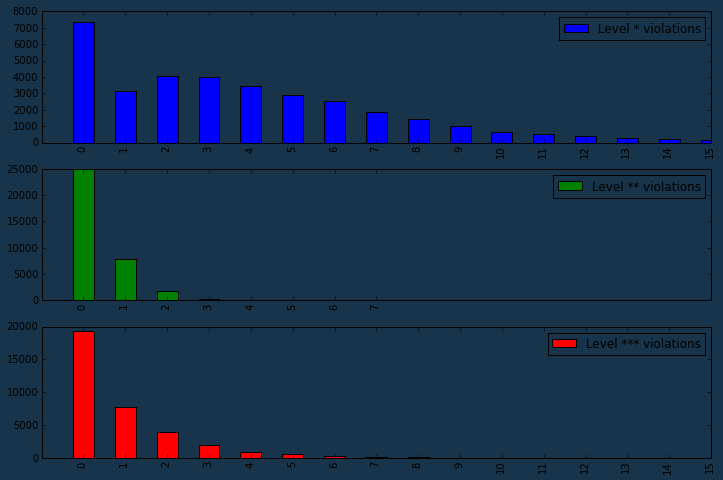

In [7]:
fig, axs = plt.subplots(3, 1)
fig.set_size_inches(12, 8)

for i, label in enumerate(['*', '**', '***']):
    data = train_labels[label]
    vc = data.value_counts()
    idxs = sorted(vc.index)
    vc[idxs].plot(kind="bar",
                  ax=axs[i],
                  xlim=(-1, 15),
                  color=plt.rcParams['axes.color_cycle'][i],
                  grid=False,
                  label='Level {} violations'.format(label))
    axs[i].legend()

<a id="features"></a>

# And now for our feature(s) presentation

---------------

Next, we'll do some text processing to create features. This is the important part of many NLP problems, but we'll just do something simple to get off the ground. [TF-IDF (term frequency, inverse document frequency)](http://en.wikipedia.org/wiki/Tf%E2%80%93idf) weights the occurrence of words based on how often they appear in the overall corpus. That is, words that appear across all the reviews will be less important than words that appear in only a few reviews.

`sklearn` has [very convenient tools to convert text to TF-IDF features](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html), so we'll use that for our benchmarking.

The first step is to create the data row-by-row for each output in the training set. For example, take the row:

`20652	2008-05-07	lnORDD3N	9	2	2`

We want to find all of the reviews of restaurant `lnORDD3N` that occurred before the inspection date `2008-05-07`. We'll then look at the occurences of words across all of these reviews, and generate a feature matrix of those words.

In [8]:
# a simple way to create a "document" for an inspection is to
# concatenate all the reviews that happened before the inspection date
def flatten_reviews(label_df, reviews):
    """ label_df: inspection dataframe with date, restaurant_id
        reviews: dataframe of reviews
        
        Returns all of the text of reviews previous to each
        inspection listed in label_df.
    """
    reviews_dictionary = {}
    
    N = len(label_df)

    for i, (pid, row) in enumerate(label_df.iterrows()):
        # we want to only get reviews for this restaurant that ocurred 1 yr before the inspection
        pre_inspection_mask = (reviews.date < row.date) & (reviews.date + np.timedelta64(180, 'D') > np.datetime64(row.date)) & (reviews.restaurant_id == row.restaurant_id)

        # pre-inspection reviews
        pre_inspection_reviews = reviews[pre_inspection_mask]
        
        # join the text
        all_text = ' '.join(pre_inspection_reviews.text)

        # store in dictionary
        reviews_dictionary[pid] = all_text
        
        if i % 2500 == 0:
            print '{} out of {}'.format(i, N)

    # return series in same order as the original data frame
    return pd.Series(reviews_dictionary)[label_df.index]

<div class="alert alert-warning">
    <p><strong>Note!</strong> The following few cells can take quite a bit of memory. If you find yourself running out of memory, you may want to work on a smaller subset of the data.</p>
    <p>
    ... or you could go buy more memory <img src="http://www.emoji-cheat-sheet.com/graphics/emojis/trollface.png" height="24" width="24" style="display: inline-block;"/></p>
</div>

In [9]:
train_text = flatten_reviews(train_labels, reviews)
train_text.head()

0 out of 34879
2500 out of 34879
5000 out of 34879
7500 out of 34879
10000 out of 34879
12500 out of 34879
15000 out of 34879
17500 out of 34879
20000 out of 34879
22500 out of 34879
25000 out of 34879
27500 out of 34879
30000 out of 34879
32500 out of 34879


20619                                                     
10144    Good delivery restaurant for South Boston.  Va...
19634                                                     
24797    Good delivery restaurant for South Boston.  Va...
20253                                                     
dtype: object

In [10]:
test1_text = flatten_reviews(submission1, reviews)
test2_text = flatten_reviews(submission2, reviews)
test1_text.head()

0 out of 6772
2500 out of 6772
5000 out of 6772
0 out of 1867


id
14916    I order from here quit alot ...I love their. M...
29767    Really funny chefs....the best part of the exp...
29338    love, Love, LOVE this place! It's a favorite f...
7219     I went here with friends to pregame First Frid...
20979    My roommate mistakenly ordered Great Wall inst...
dtype: object

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# create a TfidfVectorizer object with english stop words
# and a maximum of 1500 features (to ensure that we can
# train the model in a reasonable amount of time)
vec = TfidfVectorizer(stop_words='english',max_features=1500)
#vec = TfidfVectorizer(stop_words='english',max_features=3000)

# create the TfIdf feature matrix from the raw text
train_tfidf = vec.fit_transform(train_text)

In [12]:
# take a quick look at some of the features
pd.DataFrame(data=train_tfidf.todense(), columns=vec.get_feature_names()).iloc[:5, 30:45]

afternoon  ago  agree  ahead  air  al  alcohol  allston  alright  amazing  \
0          0    0      0      0    0   0        0        0        0        0   
1          0    0      0      0    0   0        0        0        0        0   
2          0    0      0      0    0   0        0        0        0        0   
3          0    0      0      0    0   0        0        0        0        0   
4          0    0      0      0    0   0        0        0        0        0   

   ambiance  ambience  american  annoying  anymore  
0         0         0         0         0        0  
1         0         0         0         0        0  
2         0         0         0         0        0  
3         0         0         0         0        0  
4         0         0         0         0        0

In [13]:
# create the same tfidf matrix for the test set
# so we can make predictions based on the same features
test1_tfidf = vec.transform(test1_text)
test2_tfidf = vec.transform(test2_text)

These are the features being saved by this notebook

In [14]:
train_features = train_tfidf.todense()
test1_features = test1_tfidf.todense()
test2_features = test2_tfidf.todense()


# Write the features file


In [15]:
# 
np.save(TRAINOUTFILE,train_features)
np.save(P1OUTFILE,test1_features)
np.save(P2OUTFILE,test2_features)
